<a href="https://colab.research.google.com/github/pj0620/google-colab-notebooks/blob/main/photocircuit_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Heatmap

<ipython-input-16-5b25ebfa924a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Average Percent Error (%)'] = (filtered_data['Average Error (px)'] / filtered_data['Screen Size (px)']) * 100


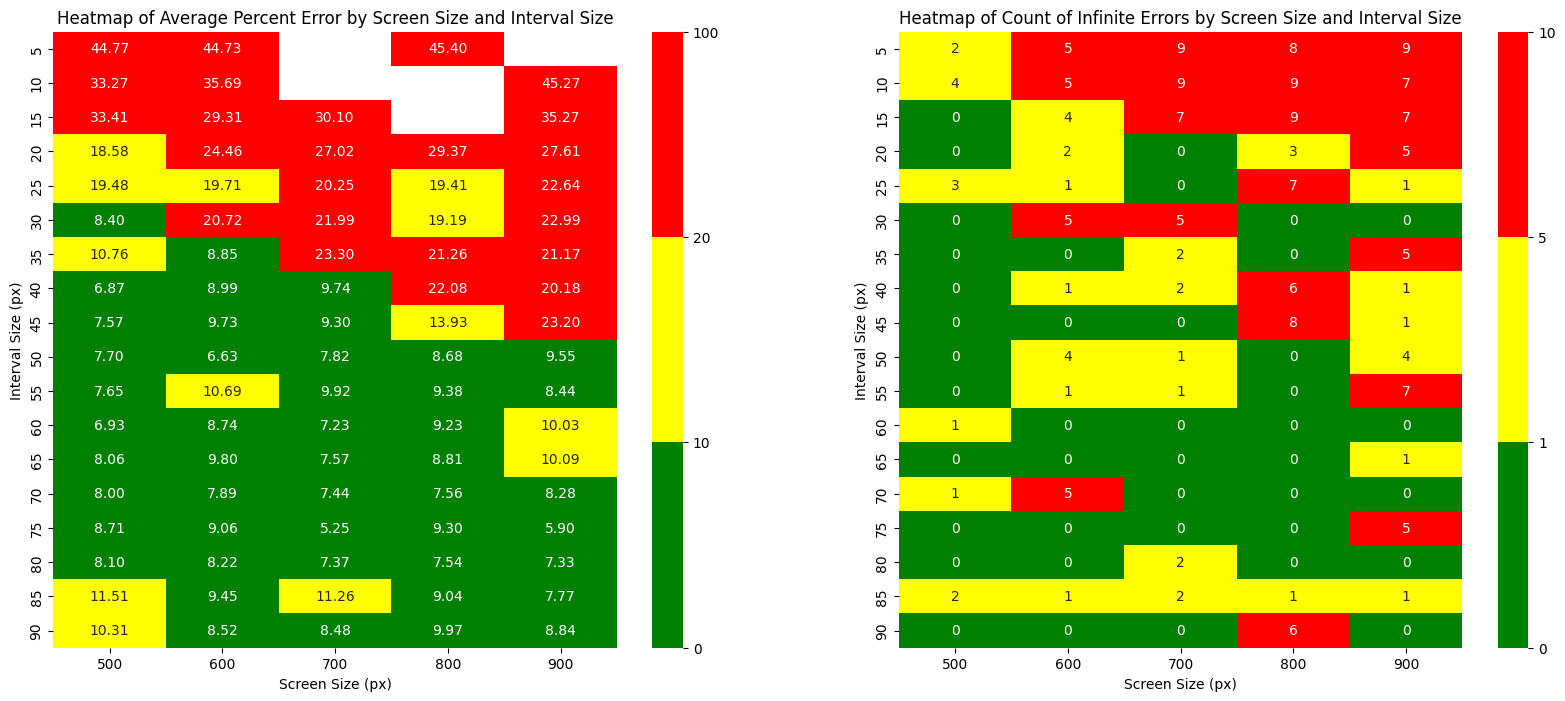

In [16]:
import pandas as pd

# Read the data from the CSV file
file_path='/content/drive/MyDrive/Photo_Circuit/data/data_analysis/screen_sizes_intv_spacing.csv'


# Read the data from the CSV file
data = pd.read_csv(file_path)

# Remove rows where Average Error is infinity for the first heatmap
filtered_data = data[data['Average Error (px)'] != float('inf')]

# Create a new column for Average Percent Error
filtered_data['Average Percent Error (%)'] = (filtered_data['Average Error (px)'] / filtered_data['Screen Size (px)']) * 100

# Calculate the mean Average Percent Error for each combination of Screen Size and Interval Size
pivot_table_percent_error = filtered_data.pivot_table(values='Average Percent Error (%)', index='Interval Size (px)', columns='Screen Size (px)', aggfunc='mean')

# Calculate the total count of infinite Average Error for each combination of Screen Size and Interval Size
data['inf_count'] = data['Average Error (px)'].apply(lambda x: 1 if x == float('inf') else 0)
pivot_table_inf_count = data.pivot_table(values='inf_count', index='Interval Size (px)', columns='Screen Size (px)', aggfunc='sum')

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Plot the heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Define a nonlinear color map
cmap_percent_error = mcolors.ListedColormap(['green', 'yellow', 'red'])
bounds_percent_error = [0, 10, 20, 100]
norm_percent_error = mcolors.BoundaryNorm(bounds_percent_error, cmap_percent_error.N)

# First heatmap: Average Percent Error
sns.heatmap(pivot_table_percent_error, annot=True, cmap=cmap_percent_error, norm=norm_percent_error, fmt=".2f", ax=axes[0])
axes[0].set_title('Heatmap of Average Percent Error by Screen Size and Interval Size')

# Define a nonlinear color map for infinite errors
cmap_inf_count = mcolors.ListedColormap(['green', 'yellow', 'red'])
bounds_inf_count = [0, 1, 5, 10]
norm_inf_count = mcolors.BoundaryNorm(bounds_inf_count, cmap_inf_count.N)

# Second heatmap: Count of Infinite Errors with red/green colormap
sns.heatmap(pivot_table_inf_count, annot=True, cmap=cmap_inf_count, norm=norm_inf_count, fmt="d", ax=axes[1])
axes[1].set_title('Heatmap of Count of Infinite Errors by Screen Size and Interval Size')

plt.show()


<ipython-input-18-565787f7f634>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Average Percent Error (%)'] = (filtered_data['Average Error (px)'] / filtered_data['Screen Size (px)']) * 100


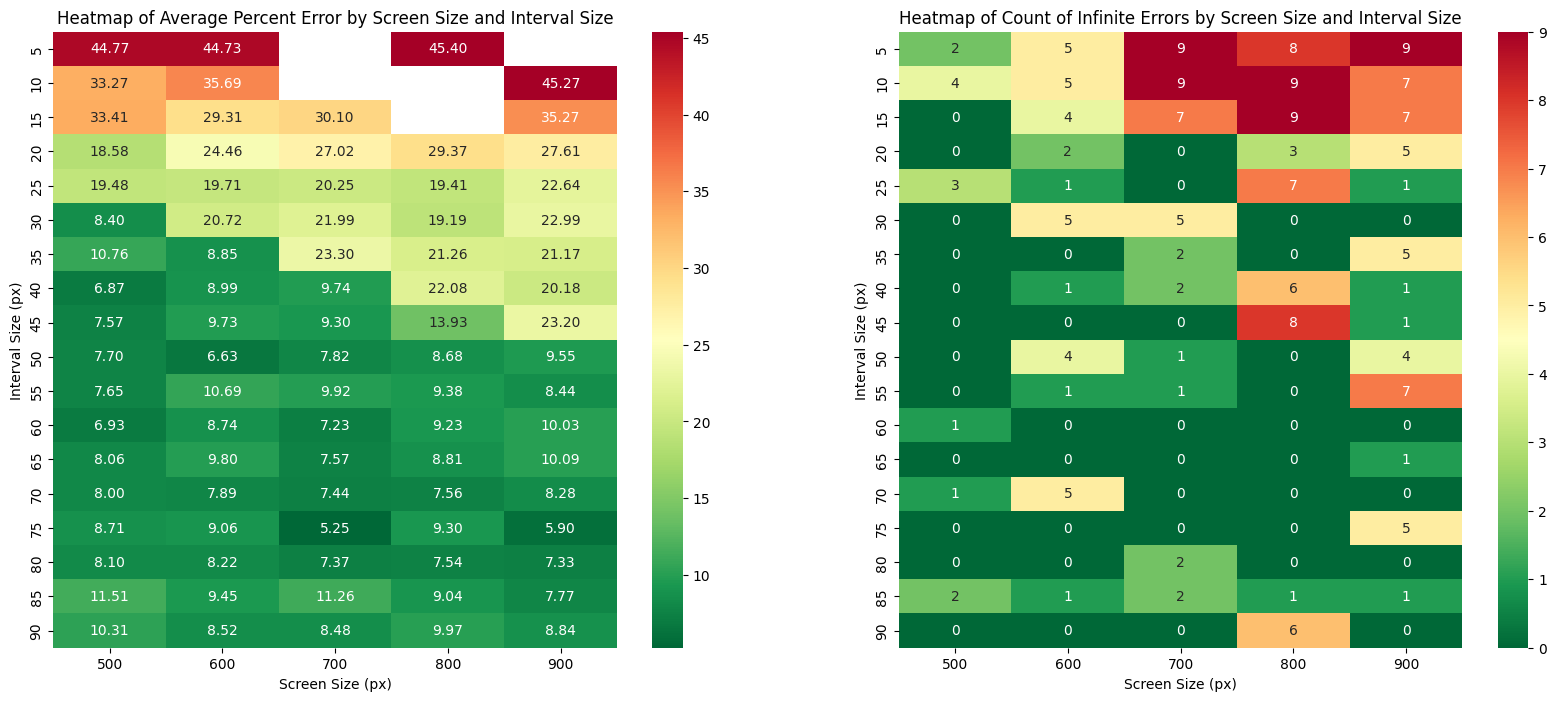

In [18]:
import pandas as pd

# Read the data from the CSV file
file_path='/content/drive/MyDrive/Photo_Circuit/data/data_analysis/screen_sizes_intv_spacing.csv'

# Read the data from the CSV file
data = pd.read_csv(file_path)

# Remove rows where Average Error is infinity for the first heatmap
filtered_data = data[data['Average Error (px)'] != float('inf')]

# Create a new column for Average Percent Error
filtered_data['Average Percent Error (%)'] = (filtered_data['Average Error (px)'] / filtered_data['Screen Size (px)']) * 100

# Calculate the mean Average Percent Error for each combination of Screen Size and Interval Size
pivot_table_percent_error = filtered_data.pivot_table(values='Average Percent Error (%)', index='Interval Size (px)', columns='Screen Size (px)', aggfunc='mean')

# Calculate the total count of infinite Average Error for each combination of Screen Size and Interval Size
data['inf_count'] = data['Average Error (px)'].apply(lambda x: 1 if x == float('inf') else 0)
pivot_table_inf_count = data.pivot_table(values='inf_count', index='Interval Size (px)', columns='Screen Size (px)', aggfunc='sum')

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the heatmaps side by side with linear color maps
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Define a linear color map for percent error
cmap_linear = 'RdYlGn_r'

# First heatmap: Average Percent Error with linear color map
sns.heatmap(pivot_table_percent_error, annot=True, cmap=cmap_linear, fmt=".2f", ax=axes[0])
axes[0].set_title('Heatmap of Average Percent Error by Screen Size and Interval Size')

# Define a linear color map for infinite errors
cmap_linear_inf = 'RdYlGn_r'

# Second heatmap: Count of Infinite Errors with linear color map
sns.heatmap(pivot_table_inf_count, annot=True, cmap=cmap_linear_inf, fmt="d", ax=axes[1])
axes[1].set_title('Heatmap of Count of Infinite Errors by Screen Size and Interval Size')

plt.show()
